<a href="https://colab.research.google.com/github/srini229/EE5333_tutorials/blob/master/fp/Floorplanning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulated Annealing

<img src="https://raw.githubusercontent.com/srini229/EE5333_tutorials/master/fp/fig/sim_anneal.jpg" width=507 height=569 />

  + Accept$(C, T) = e^{\frac{-\Delta C}{k T}}$

In [40]:
import math
import random

def accept(delC, T):
  if delC <= 0: return True
  p = math.exp(-delC/T)
  x = random.random()
  if x < p:
    return True
  return False

# F = initial slicing floorplan in Polish form
# costEval(F): cost evaluation routine
# accept(\Delta C, T): accept routine
# perturb(F): perturbation routine
def sa(Tmin, Tmax, N, alpha, F, costEval, accept, perturb):
  assert(alpha < 1. and Tmin < Tmax)
  T = Tmax
  C = costEval(F)
  minC = C
  minF = F[:]
  Clist = []
  Temp = []
  while T > Tmin:
    for i in range(N):
      Fnew = perturb(F)
      Cnew = costEval(Fnew)
      if accept(Cnew - C, T):
        C, F = Cnew, Fnew
        if minC >= Cnew:
          minC, minF = Cnew, Fnew
        Clist.append(Cnew)
        Temp.append(T)
    T = T * alpha
  import matplotlib.pyplot as plt
  plt.plot(Temp, Clist)
  plt.xlim(max(Temp), min(Temp))
  plt.xscale('log')
  return minF, minC

In [41]:
operators = {'H', 'V'} # operators corresponding to H and V slices

class Module:
  def __init__(self, name, area, aspect_ratios):
    self._name = name
    self._area = area
    self._xy = [(math.sqrt(area*r), math.sqrt(area/r)) for r in aspect_ratios]
  def __repr__(self):
    return f"'{self._name}'"

def checkBalloting(F, index):
  countOperators = 0
  for i in range(index+1):
    if F[i] in operators:
      countOperators += 1
  if 2 * countOperators >= index:
    return False
  return True

def perturb(Fi):
  F = Fi[:]
  choice = random.randint(1,3)
  last = len(F) - 1
  match choice:
    case 1:
      done = False
      while not done:
        index = random.randint(0, last)
        if F[index] in operators: continue
        if index < last and F[index+1] not in operators:
          F[index], F[index + 1] = F[index + 1], F[index]
          done = True
        elif index > 0 and F[index-1] not in operators:
          F[index], F[index - 1] = F[index - 1], F[index]
          done = True
    case 2:
      done = False
      while not done:
        index = random.randint(0, last)
        if F[index] not in operators: continue
        b = index - 1
        e = index + 1
        while b >= 0 and F[b] in operators:
          b -= 1
        while e <= last and F[e] in operators:
          e += 1
        for i in range(b+1, e):
          if F[i] == 'H': F[i] = 'V'
          elif F[i] == 'V': F[i] = 'H'
        done = True
    case _:
      done = False
      iter = 0
      while not done and iter < len(F):
        index = random.randint(0, last)
        next = index + 1 if index < last else index - 1
        if F[index] not in operators and F[next] in operators and checkBalloting(F, max(index, next)):
          F[index], F[next] = F[next], F[index]
          done = True
        elif F[index] in operators and F[next] not in operators and checkBalloting(F, max(index, next)):
            F[index], F[next] = F[next], F[index]
            done = True
        iter += 1
  return F


def _costEval(a, b, operator):
  xindexed = dict()
  yindexed = dict()
  for ai in a:
    for bi in b:
      e = (max(ai[0], bi[0]), ai[1] + bi[1]) if operator == 'H' else (ai[0] + bi[0], max(ai[1], bi[1]))
      if e[0] not in xindexed and e[1] not in yindexed:
        xindexed[e[0]] = e
        yindexed[e[1]] = e
      elif e[0] in xindexed:
        if xindexed[e[0]][1] > e[1]:
          xindexed[e[0]] = e
          yindexed[e[1]] = e
      elif e[1] in yindexed:
        if yindexed[e[1]][0] > e[0]:
          xindexed[e[0]] = e
          yindexed[e[1]] = e
  return [v for k, v in xindexed.items()]

def costEval(F):
  cost = [] # stack
  for f in F:
    if f in operators:
      assert(len(cost) >= 2)
      b = cost.pop()
      a = cost.pop()
      cost.append(_costEval(a, b, f))
    else:
      cost.append(f._xy)

  assert(len(cost) > 0)
  return min([i[0] * i[1] for i in cost[0]])


['a', 'c', 'H', 'd', 'b', 'H', 'V'] 85.0


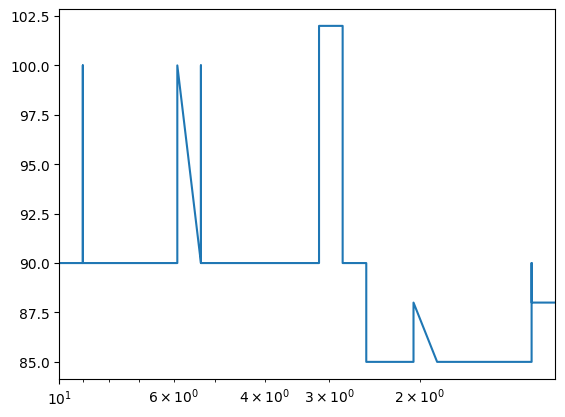

In [42]:
a = Module('a', 16, [0.25, 4])
b = Module('b', 32, [0.5, 2])
c = Module('c', 27, [1./3., 3.])
d = Module('d', 6, [3./2., 6., 1./6.])
F = [a, b, 'V', c, 'V', d, 'V']
#F = [c, a, b, 'V', d, 'H', 'V']
Cmin, Fmin = sa(1, 10, 10, 0.9, F, costEval, accept, perturb)
print(Cmin, Fmin)

['16', '5', '17', '7', '4', '18', 'H', 'H', '11', '6', 'H', 'H', 'H', '12', 'H', '9', '1', '10', 'H', 'H', '15', '14', 'H', '0', '8', 'H', 'H', 'H', 'V', 'H', '2', '19', 'H', '3', '13', 'H', 'V', 'H', 'H'] 6156.882939074371


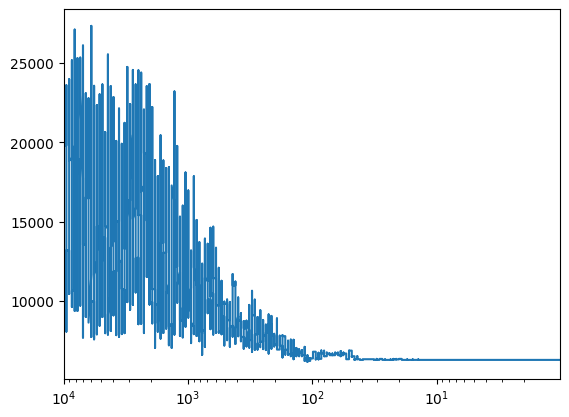

In [52]:
m = [Module(str(i), random.randint(100, 400), [random.randint(10, 20)]) for i in range(20)]
F = [m[0]]
for i in range(1, len(m)):
  F.append(m[i])
  F.append('V')
Cmin, Fmin = sa(1, 10000, 1000, 0.95, F, costEval, accept, perturb)
print(Cmin, Fmin)